# Hands-On ML: Chapter 5, Support Vector Machines

In this chapter, we will devote a lot of time to SVM. SVM is one of the most powerful and versatile ML model. It can perform linear/nonlinear classification, regression and even outlier detection. It is particularly well-suited for **complex classification of small to medium datasets**. We will skip the derivation for maximizing margin since we went through that is other textbook. The only new thing to think about is soft vs hard margins. Hard margins is the typical support vector derivation, it is quite sensitive to outliers and only really works with clean, linearly separable data.

Summary

1. Linear SVM
2. Linear SVM with Nonlinear Features
3. Similarity Features
4. Computational Complexity of LinearSVM and SVM
5. SVM Regression

In [3]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris['data'][:, (2,3)] #get petal length and petal width
y = (iris['target'] == 2).astype(np.float64) #Iris-Virginica

#create svm pipeline
svm_clf = Pipeline((
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C = 1, loss = 'hinge')) #we need hinge loss for SVM
))

svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [4]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

In [7]:
#Nonlinear SVM
#One approach is to use splines or polynomials and create new features
#Linear SVM with polynomial features
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline((
    ('poly_features', PolynomialFeatures(degree = 3)),
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C = 10, loss = 'hinge'))
))
    
polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

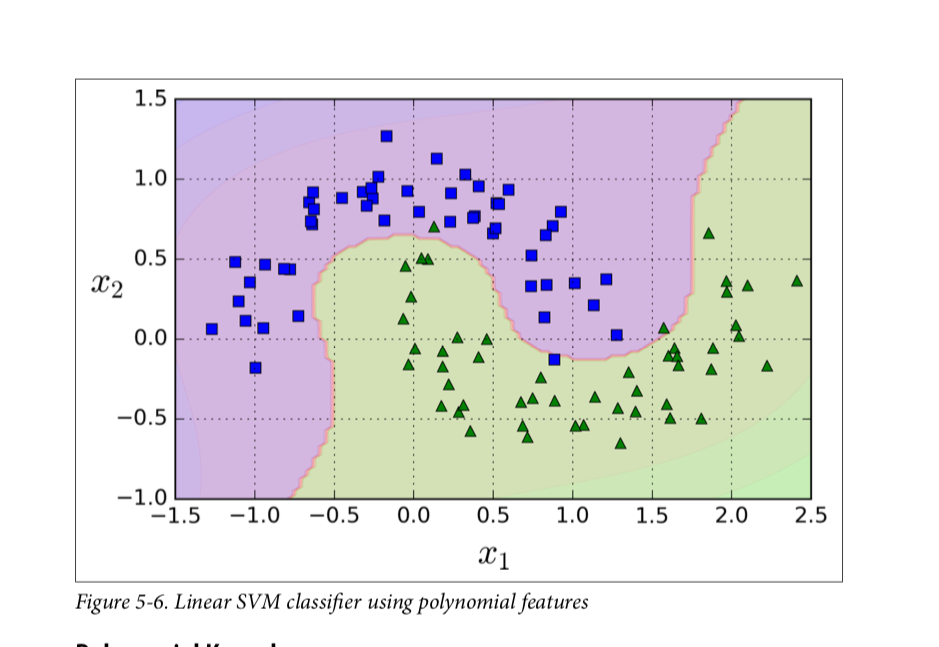

In [8]:
from IPython.display import Image
Image(filename='./images/polynomial_svm.png') 

### (Polynomial) Kernel

The polynomial features method has limitation. If we set a low degree, it cannot fit very complicated datasets. If we set a high degree, the number of features will explode and the model will be too slow. Using SVMs, we can do the *kernel trick* which makes it possible to get the same result as adding a bunch of polynomial features without actually having to add them. 

In [9]:
from sklearn.svm import SVC

#kernel polynomial, degree = 3, coef0 is the independent term in either 'poly' or 'sigmoid' kernels
#C is the regularization term
poly_kernel_svm_clf = Pipeline((
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel = 'poly', degree = 3, coef0 = 1, C = 5))
))

poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

### Similarity Features for Nonlinear Problems

Another technique to tackle nonlinear problems is to add features computed using similarity function that measures how much each instance resembles a particular **landmark**. This is somewhat similar to our polynomial feature approach in the sense that we increase the number of features. The idea is that instances may be linearly separable when we add new features to represent where an instance lies in one feature space relative to landmarks. Its confusing but look at this diagram:

Feature X1:  <----OOOO------PPPP------OOOO-----> 

The class relationship between class O & P in X1 is non-linear. But if we create landmarks and measure some similarity to those landmarks, we might create a linear boundary.

Feature X1: <----OOOO--x---PPPP--x---OOOO----->  (Landmarks x)

The diagram below uses a Gaussian RBF to measure the similarity of instance X in feature X1 relative to the two landmarks 

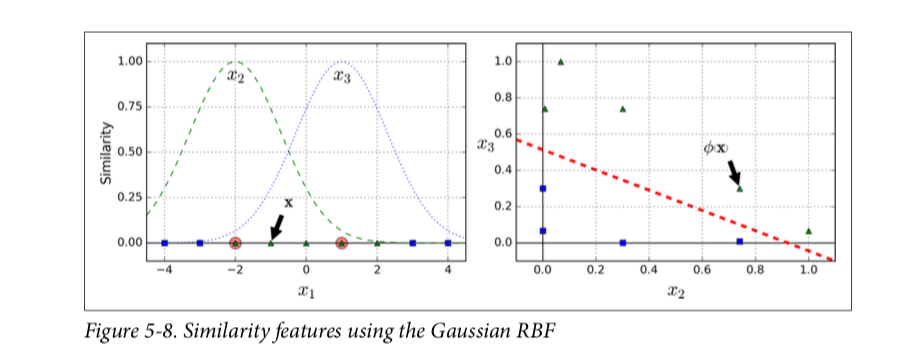

In [10]:
#Gamma controls the width of the bell curves, lower gamma, wider curve.
#This makes the decision boundary smoother because more instances will register a high x2, x3 relative to the landmarks.
#If we increase gamma, the boundary can fit closer as it sees more differences between instances relative to landmarks.
Image(filename = './images/similarity_features.png')

In [11]:
#Guassian RBF Kernel
#gamma is the kernel coefficient for rbf, poly or sigmoid
#C is regularization term
rbf_kernel_svm_clf = Pipeline((
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel = 'rbf', gamma = 5, C = 0.001))
))
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

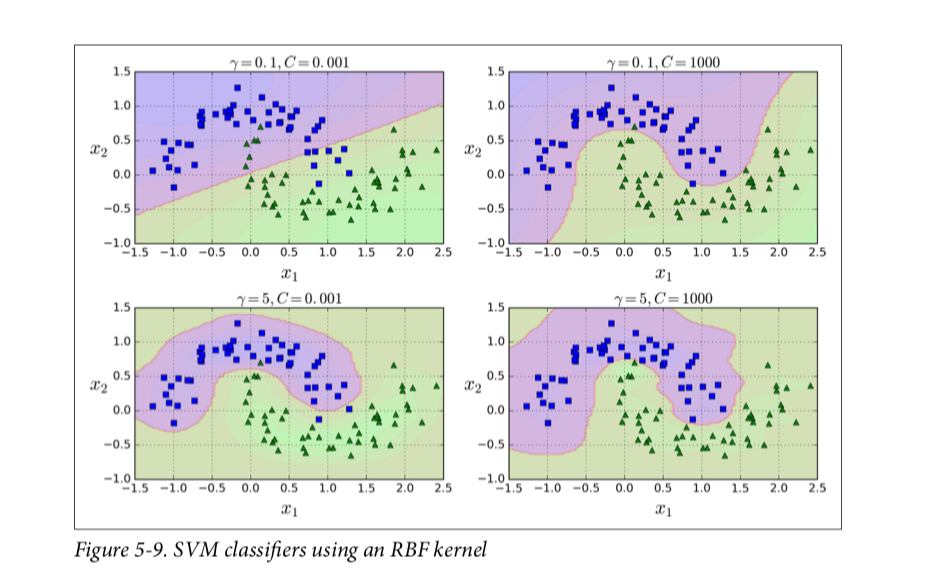

In [13]:
#Check out gamma and C affect the decision boundary
#Higher C means less regularization and the boundary can fit closer
#Gamma
Image(filename = './images/rbf_kernel.png')

### Computational Complexity

1) **LinearSVC** is based on the liblinear library, which implements optimized algorithm for linear SVMs. It does not support the kernel trick, but it scales almost linearly with data size; its training time complexity is roughly O(m x n). It will require more time if we need higher precision, controlled by tol or epsilon. We usually don't need higher than default precision though.

2) **SVC** Class is based on the libsvm library which implements Sequential Minimum Optimization (which supports the kernel trick). Unfortunately, the complexity is usually between O(m^2 x n) and O(m^3 x n). Hence, SVM gets incredibly slow for large datasets. It scales well with the number of features (n), aka more complicated datasets.


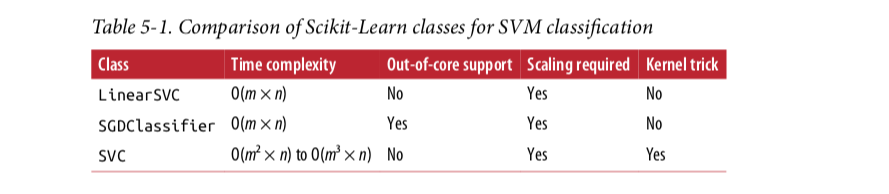

In [14]:
Image(filename = './images/svm_complexity.png')

### SVM Regression

SVM can easily run linear & non-linear regression problems. The trick is to reverse the objective. Instead of trying to maximize the margin while limiting instances violating margin rules (hard or soft), we want to maximize the number of instances **within** the margins while limiting margin violations. The width of the margin is controlled by epsilon. The prediction will be the center line inside the margin. Note that this regression is "e-insensitive", it doesn't matter how many instances we fit in the margin, the prediction will still be line y-hat. We will switch from `SVM` to `SVR` classes for both linear and nonlinear.

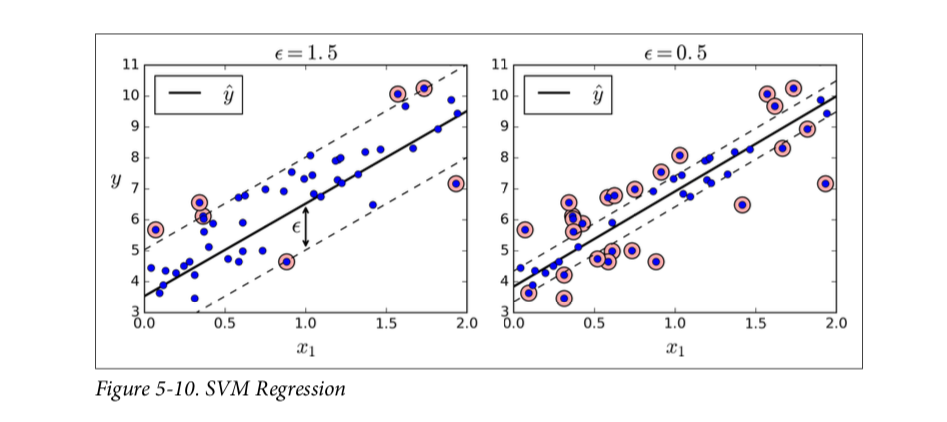

In [15]:
Image(filename = './images/svm_regression.png')

In [16]:
#Linear SVM regression
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon = 1.5)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [17]:
#Quadratic SVM regression
#The margin and y-hat line are 2nd degree (quadratic shape)
from sklearn.svm import SVR
svm_poly_reg = SVR(kernel = 'poly', degree = 2, C = 100, epsilon = 0.1)
svm_poly_reg.fit(X, y)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1,
  gamma='auto_deprecated', kernel='poly', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
from sklearn.svm import SVR
svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1,
  gamma='auto_deprecated', kernel='poly', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)